In [16]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import support_functions as sf

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from tqdm.notebook import tqdm
import copy

from aix360.metrics.local_metrics import faithfulness_metric
from aix360.metrics.local_metrics import monotonicity_metric

# sharp plots with higher resolution
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

In [17]:
def gaussian_generator(center, eig_val, eig_vec, size):
    sigma = np.matmul(np.matmul(eig_vec, eig_val), np.transpose(eig_vec))
    data_set = np.random.multivariate_normal(center, sigma, size)

    return data_set

In [18]:
n_1 = 1000  # number of the elements
mu_1 = np.array([0, 0])  # center (centroid)

# sigma is expected to be positive  semi-definite matrix
w_1 = np.array([[1.5, 0], [0, 4.5]])  # eigenvalues
v_1 = np.array([[0.4, 0], [0, 0.4]])  # eigenvectors

data_set = gaussian_generator(mu_1,w_1, v_1, n_1)


rotation_angle = np.pi / 2
rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

coord_data = np.transpose(data_set[:, 0:2])
data_set[:, 0:2] = np.transpose(np.matmul(rotation_matrix, coord_data))

#data_set_0 = data_set[data_set[:, -1] == 0]
#data_set_1 = data_set[data_set[:, -1] == 1]


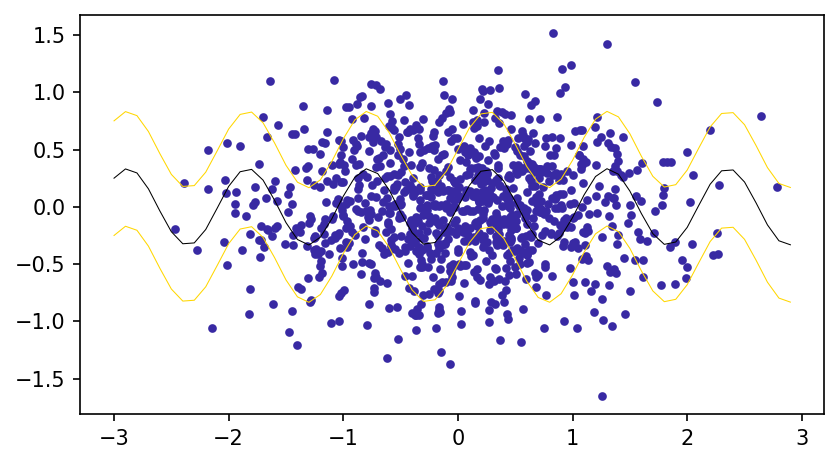

In [19]:
theta = np.linspace(-3, 3, 60, endpoint=False)

hyper_surface = np.sin(theta * 6) / 3
support_surface_1 = hyper_surface - 0.5
support_surface_2 = hyper_surface + 0.5

fig_1, ax_11 = plt.subplots()
ax_11.scatter(data_set[:, 0], data_set[:, 1], color= '#3829a3', s=10)
ax_11.plot(theta, hyper_surface, color='black', linewidth=0.5)
ax_11.plot(theta, support_surface_1, color='gold', linewidth=0.5)
ax_11.plot(theta, support_surface_2, color='gold', linewidth=0.5)
#ax_11.scatter(data_set_1[:, 0], data_set_1[:, 1], color= '#e1177e', s=10)
ax_11.set_aspect('equal')


plt.show()

In [20]:
# generate labels
data_set_0 = data_set[data_set[:, -1] <= np.sin(data_set[:, 0] * 6) / 2 - 0.5]
data_set_1 = data_set[data_set[:, -1] >= np.sin(data_set[:, 0] * 6) / 2 + 0.5]
data_set_m = data_set[(data_set[:, -1] > np.sin(data_set[:, 0] * 6) / 2 - 0.5) & (data_set[:, -1] < np.sin(data_set[:, 0] * 6) / 2 + 0.5)]
np.random.shuffle(data_set_m)
data_set_m_0, data_set_m_1 = train_test_split(data_set_m, train_size=0.5, test_size=0.5)

data_set_0 = np.vstack([data_set_0, data_set_m_0])
data_set_1 = np.vstack([data_set_1, data_set_m_1])

data_set_0 = np.hstack([data_set_0, np.zeros((len(data_set_0), 1))])
data_set_1 = np.hstack([data_set_1, np.ones((len(data_set_1), 1))])

data_set = np.vstack([data_set_0, data_set_1])
np.random.shuffle(data_set)

In [21]:
#rotation_angle = np.pi / 4
#rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)], [np.sin(rotation_angle), np.cos(rotation_angle)]])

#coord_data = np.transpose(data_set[:, 0:2])
#data_set[:, 0:2] = np.transpose(np.matmul(rotation_matrix, coord_data))

data_set_0 = data_set[data_set[:, -1] == 0]
data_set_1 = data_set[data_set[:, -1] == 1]

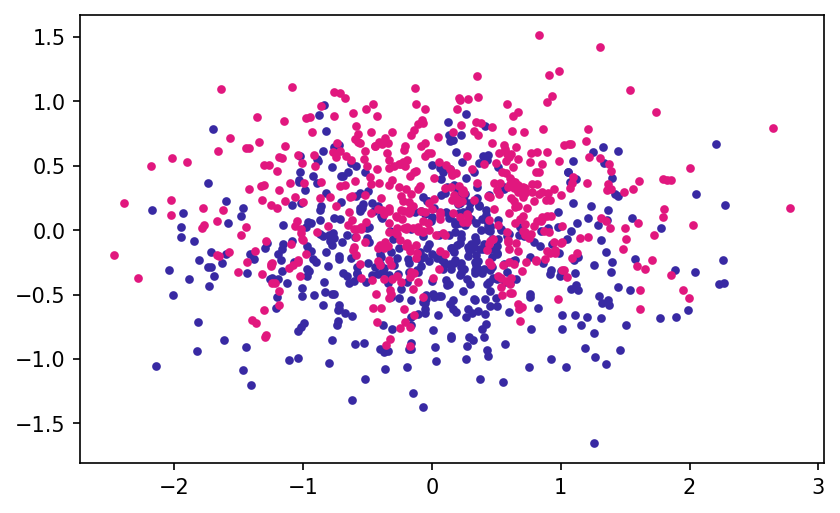

In [22]:
fig_2, ax_2 = plt.subplots()
ax_2.scatter(data_set_0[:, 0], data_set_0[:, 1], color= '#3829a3', s=10)
ax_2.scatter(data_set_1[:, 0], data_set_1[:, 1], color= '#e1177e', s=10)

ax_2.set_aspect('equal')

plt.show()

In [23]:
X = data_set[:, 0:2].copy()
y = data_set[:, 2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3, train_size=0.7)

In [24]:
clf_svc = SVC(kernel='rbf', probability=True)
clf_tree = tree.DecisionTreeClassifier()
clf_KNN = KNeighborsClassifier()
clf_GNB = GaussianNB()

In [25]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=["feat1","feat2"],
                                                  class_names=["class1","class2"], mode='classification',
                                                discretize_continuous=False)

In [11]:
shap.initjs()

In [26]:
n_test = len(X_test)
exp_weights_svc = np.zeros((n_test, 2))
flat_grid, grid_elements  = sf.get_grid(data_set=X_test, step_size=0.1, idx_column=False)

In [17]:
explainer = 'Kernel'

y_hat, hat_grid, exp_grid_weights= sf.classify_and_explain(X_train, X_test, y_train, y_test, flat_grid, clf_svc,  explainer, data_name='original', print_metrics=False)


Using 700 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using:  str
shap


  0%|          | 0/2809 [00:00<?, ?it/s]

In [18]:
y_hat_l, hat_grid_l, exp_grid_weights_l= sf.classify_and_explain(X_train, X_test, y_train, y_test, flat_grid, clf_svc,  explainer_lime, data_name='original', print_metrics=False)

Using:  LimeTabularExplainer
lime


In [19]:
plt.rcParams['figure.figsize'] = [10, 10]
fig_3, ((ax_31, ax_32), (ax_33, ax_34)) = plt.subplots(2,2, layout='constrained')
plt.subplot(221)
plt.title('lime voting of the first feature')
ax_31.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights_l[:, 0], cmap='RdBu', s=10, alpha=0.7)
ax_31.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_31.set_aspect('equal')

plt.subplot(222)
plt.title('shap voting of the first feature')
ax_32.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights[0][:, 0], cmap='RdBu', s=10, alpha=0.7)
ax_32.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_32.set_aspect('equal')

plt.subplot(223)
plt.title('lime voting of the second feature')
ax_33.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights_l[:, 1], cmap='RdBu', s=10, alpha=0.7)
ax_33.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_33.set_aspect('equal')

plt.subplot(224)
plt.title('shap voting of the second feature')
ax_34.scatter(flat_grid[:, 0], flat_grid[:, 1], c= exp_grid_weights[0][:, 1], cmap='RdBu', s=10, alpha=0.7)
ax_34.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', s=1)
ax_34.set_aspect('equal')
plt.show()

In [41]:
def get_coefficients(index, X_test, classifier, lime_explainer):
    exps_instance = lime_explainer.explain_instance(X_test[index], classifier.predict_proba, num_features=2, top_labels=2)
    predicted_class = classifier.predict(X_test[index].reshape(1, -1))[0]
    #print("Predicted class: ", predicted_class)
    local_exps = exps_instance.local_exp[predicted_class]
    #print("Local explanations: ", local_exps)
    coefs = np.zeros(X_test.shape[1])
    for v in local_exps:
        coefs[v[0]] = v[1]
    return local_exps, exps_instance, coefs

In [47]:
def classify_explain_evaluate(X_train, X_test, y_train, y_test, flat_grid, classifier, explainer, data_name,
                              print_metrics):
    classifier.fit(X_train, y_train)
    y_hat = classifier.predict(X_test)
    classifier_name = type(classifier)

    if print_metrics:
        print(data_name, ' ', classifier_name, ' accuracy score: ', accuracy_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' precision score: ', precision_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' recall score: ', recall_score(y_test, y_hat))
        print(data_name, ' ', classifier_name, ' f1 score: ', f1_score(y_test, y_hat))

    hat_grid = classifier.predict(flat_grid)

    explainer_type_internal = type(explainer).__name__
    print('Using: ', explainer_type_internal)
    exp_grid_weights = []
    if explainer_type_internal == 'LimeTabularExplainer':
        print('lime')
        x = flat_grid[:, 0]
        n_grid = len(flat_grid)
        exp_grid_weights = np.zeros((n_grid, 2))
        faithfulness = np.zeros((n_grid, 1))
        monotonicity = np.zeros((n_grid, 1))

        for i in range(0, n_grid-1):
            #le, exp_svc_rot, coefs = get_coefficients(i, X_test, classifier, explainer)
            exp_svc_rot = explainer.explain_instance(data_row=flat_grid[i, :], predict_fn=classifier.predict_proba, num_features=2, top_labels=2)
            predicted_class = classifier.predict(flat_grid[i,:].reshape(1, -1))[0]
            local_exps = exp_svc_rot.local_exp[predicted_class]
            coefs = np.zeros(X_test.shape[1])
            for v in local_exps:
                coefs[v[0]] = v[1]

            base = np.zeros(flat_grid[i, :].shape[0])
            
            faithfulness[i, 0] = faithfulness_metric(classifier, flat_grid[i, :], coefs, base)
            monotonicity[i, 0] = monotonicity_metric(classifier, flat_grid[i, :], coefs, base)


            #a =exp_svc_rot.as_list()
            exp_grid_weights[i, 1] = exp_svc_rot.as_list()[0][1]
            exp_grid_weights[i, 0] = exp_svc_rot.as_list()[1][1]  # NB!  observe the chane of indexes due to the fact
            # that second feature comes first

    elif explainer_type_internal == 'str':
        print('shap')
        explainer_shap = shap.KernelExplainer(classifier.predict_proba, X_train)
        exp_grid_weights = explainer_shap.shap_values(flat_grid)

    return y_hat, hat_grid, exp_grid_weights, faithfulness, monotonicity

In [48]:
y_hat_l, hat_grid_l, exp_grid_weights_l, faithfulness, monotonicity = classify_explain_evaluate(X_train, X_test, y_train, y_test, flat_grid, clf_svc,  explainer_lime, data_name='original', print_metrics=False)

Using:  LimeTabularExplainer
lime


[[-1.]
 [-1.]
 [ 1.]
 ...
 [-1.]
 [-1.]
 [ 0.]]


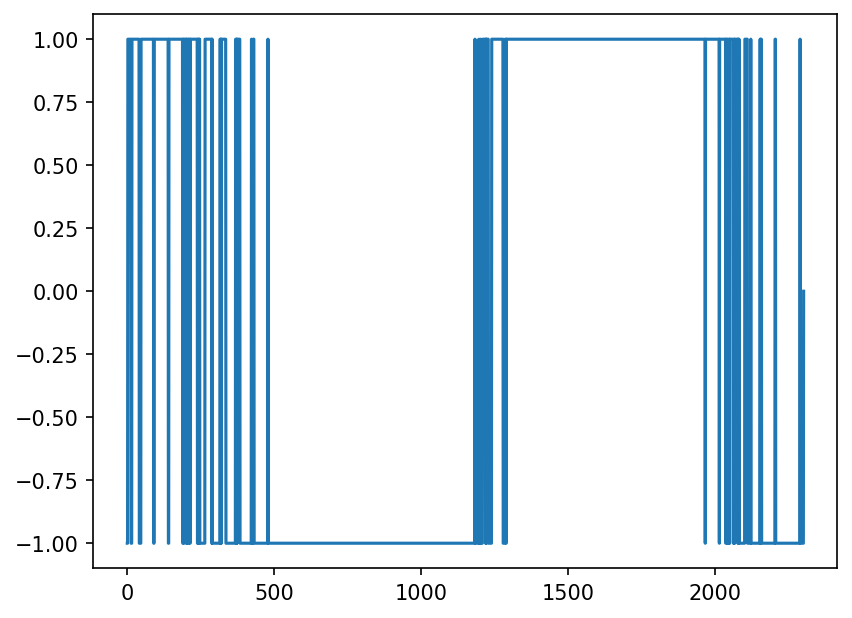

In [52]:
print(faithfulness)
plt.plot(faithfulness)